## Convolutional Neural Network that is trained to distinguish emotions (Keras)

- Number of pictures: **36 076 (size 48 by 48)**
- Number of emotions to classify: **7**
- Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

**Convert csv to images:** <br>
This is **not** a required step, but I had curiosity to see how images looked like before they were converted to csv. The initial file provided in kaggle - csv file.

This code transforms csv back to images, saving the category of the image in the name of the images. This allows to distinguish categories easier in the future.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

df = pd.read_csv('fer2013.csv', sep=',')
h,w = 48,48 #setting width and height

for i in range(len(df)):
    input = df.iloc[i, 1]
    my_list = input.replace(" ", ",").split(",") #replace spaces and convert to list
    narray = np.asarray(my_list)
    img = Image.fromarray(np.uint8(narray.reshape(h,w)) , 'L')
    label = df['emotion'][i]
    img.save(str(label)+"_"+str(i)+'image.png')

**Example of a image**

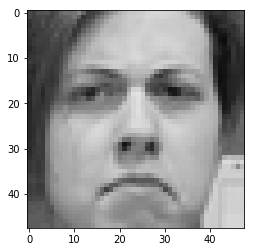

In [175]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('data/train/0/0_40image.png', 'r').convert('RGB')
imshow(np.asarray(pil_im))

Import Kaggle

In [8]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

### Build CNN Model

**Initialising the CNN**

In [9]:
classifier = Sequential()

**First convolutional layer** <br>
64 - number of feature detectors of size 5 by 5 <br>
Relu as an activation function <br>
Even though pictures initialy were white-and-black, the number of channels is 3. Converting csv back to pictures applied channel 3

In [10]:
classifier.add(Conv2D(64, (5, 5), input_shape = (48, 48, 3), activation = 'relu', data_format="channels_last")) #some mistake, needs 3, but pictures are not colorful

**Pooling Step** <br>
Size of a stride: 2 by 2

In [11]:
classifier.add(MaxPooling2D(pool_size = (2, 2)))

**Second convolutional and pooling layers** <br>
64 - number of feature detectors of size 5 by 5 <br>
Relu as an activation function <br>
Size of a stride: 3 by 3

In [12]:
classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (3, 3)))

**Flattening**

In [13]:
classifier.add(Flatten())

**Dense layers**<br>
units = 7 - number of categories <br>
softmax is better as an activation function for models with >2 categories

In [14]:
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 7, activation = 'softmax'))

**Compile the CNN**

In [15]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Fitting images into a model

**Rotating, rescalling, zooming images - creating new pictures from old ones;enriching and preventing overfitting**

In [17]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, #all pixels between 0 and 1
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, #zooming
                                   horizontal_flip = True) #flipping horizontally
                                    #there are more transformations in docs

Rescale test data

In [19]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (48, 48), #size of images that are expected
                                                 batch_size = 10, #after what number of phoos weights will be updated
                                                 class_mode = 'categorical') 

test_set = test_datagen.flow_from_directory('data/test',
                                            target_size = (48, 48),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 29300 images belonging to 7 classes.
Found 6770 images belonging to 7 classes.


In [21]:
classifier.fit_generator(training_set,
                         steps_per_epoch = (29300/10), #size of a batch
                         epochs = 25,
                         validation_data = test_set,
                         validation_steps = (6776/10))

Epoch 1/25
2930/2930 [==============================] - 1016s 347ms/step - loss: 1.6488 - acc: 0.3429 - val_loss: 1.4820 - val_acc: 0.4173
Epoch 2/25
2930/2930 [==============================] - 331s 113ms/step - loss: 1.4503 - acc: 0.4447 - val_loss: 1.3899 - val_acc: 0.4616
Epoch 3/25
2930/2930 [==============================] - 330s 113ms/step - loss: 1.3822 - acc: 0.4646 - val_loss: 1.3504 - val_acc: 0.4716
Epoch 4/25
2930/2930 [==============================] - 295s 101ms/step - loss: 1.3344 - acc: 0.4907 - val_loss: 1.3146 - val_acc: 0.4870
Epoch 5/25
2930/2930 [==============================] - 294s 100ms/step - loss: 1.2962 - acc: 0.5079 - val_loss: 1.2785 - val_acc: 0.5034
Epoch 6/25
2930/2930 [==============================] - 312s 107ms/step - loss: 1.2620 - acc: 0.5178 - val_loss: 1.2941 - val_acc: 0.5078
Epoch 7/25
2930/2930 [==============================] - 307s 105ms/step - loss: 1.2406 - acc: 0.5257 - val_loss: 1.2525 - val_acc: 0.5164
Epoch 8/25
2930/2930 [===========

The accuracy of a model is aroung 54%. I suppose more epochs, more complicated model can improve the quality. Moreover, some emotions (Anger, Disgust) are similar and photos of these categories look alike, so it is hard to distinguish some of categories from one another.

### Predict category for a single image <br>
Now, after the model was trained, a prediction on new images can be made. A single image from test data will be categorized to find what emotion is presented on this image.

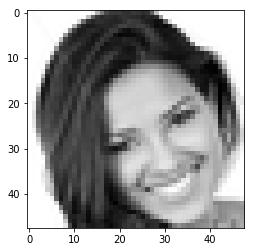

In [176]:
image_example = Image.open('data/test/3/3_13991image.png', 'r').convert('RGB')
imshow(np.asarray(image_example))

This is an image of a label "Happy"

**Reshape the image**

In [166]:
from scipy.misc import imread,imresize

x=imread('3_13991image.png',mode='RGB')
x=imresize(x,(48,48))
x=np.invert(x)
x=x.reshape(-1,48,48,3)

In [167]:
x = x/255.

**Predict emotion on the image**

In [168]:
prediction = classifier.predict(x)

**Chunk of code that tranforms index in the emotion name**

In [169]:
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"  
}

**Index of the prediction**

In [171]:
np.argmax(prediction)

3

**Transform index to label/emotion**

In [172]:
labels.get(np.argmax(prediction))

'Happy'